In [1]:
import tensorflow as tf
import scipy.io.wavfile as wav
import glob
import numpy as np
from six.moves import xrange as range
import json
from python_speech_features import mfcc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import (Input, Lambda)
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint  
import librosa 

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import gc

# import mlflow

In [2]:
# Constants 
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = 1
FEAT_MASK_VALUE = 1e+10

# Some configs
# filters=200
# kernel_size=11
# conv_stride=2
# conv_border_mode='valid'
units=200
num_features = 13
num_units = 100
num_classes = 222 + 1 # 285(including space) + blamk label = 286

# Hyper-parameters
num_epochs = 100
num_layers = 1
batch_size = 16
initial_learning_rate = 0.0005
momentum = 0.9

In [3]:
# Loading the data
file_path = glob.glob('/home/dibora_gebreyohannes/AMH-STT/data/train/wav/*.wav')
# file_path = file_path[28:32]
audio_list = []
fs_list = []
dur_list = []
dropped_file_path = []

for file_name in file_path:
    audio,fs = librosa.load(file_name,sr=16000)
    dur = librosa.get_duration(audio,sr=16000)
    if dur > 2 and dur < 6:
        dropped_file_path.append(file_name)
        audio_list.append(audio)
        dur_list.append(dur)
        fs_list.append(fs)
    

In [4]:
len(audio_list)

724

In [5]:
# Create a dataset composed of data with variable lengths
inputs_list = []
for index in range(len(audio_list)):
    input_val = mfcc(audio_list[index], samplerate=fs_list[index])
    input_val = (input_val - np.mean(input_val)) / np.std(input_val)
    inputs_list.append(input_val)

# Transform in 3D Array
train_inputs = tf.ragged.constant([i for i in inputs_list], dtype=np.float32)
train_seq_len = tf.cast(train_inputs.row_lengths(), tf.int32)
train_inputs = train_inputs.to_tensor(default_value=FEAT_MASK_VALUE)

In [6]:
with open('labels.json', 'r', encoding='UTF-8') as label_file:
    labels = json.load(label_file)
with open('language_model.json', 'r', encoding='UTF-8') as language_file:
    alphabets = json.load(language_file)


In [7]:
# Reading Targets
original_list = []
targets_list = []

for path in dropped_file_path:
    file_name = path[:-4].split('wav')[1][1:]
    # Read Label
    label = labels[file_name]
    original = " ".join(label.strip().split(' '))
    original_list.append(original)
#     print(original)
    target = original.replace(' ', '  ')
    # print('step-1. ',target)
    target = target.split(' ')
    # print('step-2. ', target)
    # Adding blank label
    target = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in target])
    # print('step-3. ', target)
    # Transform char into index
    target = np.asarray([alphabets['char_to_num'][x] for x in target])
    # print('step-4. ', target)
    targets_list.append(target)

In [8]:
# Creating sparse representation to feed the placeholder
train_targets = tf.ragged.constant([i for i in targets_list], dtype=np.int32)
train_targets_len = tf.cast(train_targets.row_lengths(), tf.int32)
train_targets = train_targets.to_sparse()

In [9]:
val_inputs, val_targets, val_seq_len, val_targets_len = train_inputs, train_targets, train_seq_len, train_targets_len


In [10]:
class CTCLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        labels = inputs[0]
        logits = inputs[1]
        label_len = inputs[2]
        logit_len = inputs[3]

        logits_trans = tf.transpose(logits, (1,0,2))
        label_len = tf.reshape(label_len, (-1,))
        logit_len = tf.reshape(logit_len, (-1,))
        loss = tf.reduce_mean(tf.nn.ctc_loss(labels, logits_trans, label_len, logit_len, blank_index=-1))
        # define loss here instead of in compile
        self.add_loss(loss)

        # Decode
        decoded, _ = tf.nn.ctc_greedy_decoder(logits_trans, logit_len)

        # Inaccuracy: label error rate
        ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),labels))
        self.add_metric(ler, name='ler', aggregation='mean')

        return logits


In [11]:
# Defining Training Cells
num_units = 50
cells = []
for _ in range(num_layers):
    cell = tf.keras.layers.GRUCell(num_units)
    cells.append(cell)

stack = tf.keras.layers.StackedRNNCells(cells)


In [12]:
# Definning Input Parameters
input_feature = tf.keras.layers.Input((None, num_features), name='input_feature')
input_label = tf.keras.layers.Input((None,), dtype=tf.int32, sparse=True, name='input_label')
input_feature_len = tf.keras.layers.Input((1,), dtype=tf.int32, name='input_feature_len')
input_label_len =tf.keras.layers.Input((1,), dtype=tf.int32, name='input_label_len')

input_masking = tf.keras.layers.Masking(FEAT_MASK_VALUE)(input_feature)
x = tf.keras.layers.LSTM(100,return_sequences=True)(input_masking)
x_1 = tf.keras.layers.BatchNormalization()(x)
x_2 = tf.keras.layers.LSTM(100,return_sequences=True)(x_1)
# x_3= tf.keras.layers.BatchNormalization()(x_2)
# x = tf.keras.layers.LSTM(50,return_sequences=True)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# layer_rnn = tf.keras.layers.LSTM(10, return_sequences=True)(layer_bn)
# x = tf.keras.layers.Dropout(0.2, seed=42)(x)
layer_output = tf.keras.layers.TimeDistributed(Dense(num_classes, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0,0.1), bias_initializer='zeros', name='logit'))(x_2)

layer_loss = CTCLossLayer()([input_label, layer_output, input_label_len, input_feature_len])


In [13]:
# Create models for training and prediction
model_train = tf.keras.models.Model(inputs=[input_feature, input_label, input_feature_len, input_label_len],
            outputs=layer_loss)
print(model_train.summary())
model_predict = tf.keras.models.Model(inputs=input_feature, outputs=layer_output)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_feature (InputLayer)      [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 13)     0           input_feature[0][0]              
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 100)    45600       masking[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 100)    400         lstm[0][0]                       
______________________________________________________________________________________________

In [14]:
# Compile Training Model with selected optimizer
optimizer = tf.keras.optimizers.SGD(initial_learning_rate, momentum)
model_train.compile(optimizer=optimizer)

checkpointer = ModelCheckpoint(filepath='../models/'+"RNN"+'.h5',monitor='ler',verbose=1, save_best_only=True, mode='min')
# ModelCheckpoint(filepath='../models/'+"RNN"+'.h5', verbose=0,)

# Training, Our y is already defined so no need# mlflow.tensorflow.autolog()
history = model_train.fit(x=[train_inputs, train_targets, train_seq_len, train_targets_len], y=None,
                validation_data=([val_inputs, val_targets, val_seq_len, val_targets_len], None),
                batch_size=batch_size, epochs=300,callbacks=[checkpointer])

# try:
#     experiment_id = mlflow.create_experiment("Stacked RNN(LSTM): 50 Cells")
#     experiment = mlflow.get_experiment(experiment_id)
# except mlflow.exceptions.MlflowException:
#     experiment = mlflow.get_experiment_by_name("Stacked RNN(LSTM): 50 Cells")



Epoch 1/300
46/46 [==============================] - 12s 103ms/step - loss: 660.2971 - ler: 0.9289 - val_loss: 184.4509 - val_ler: 0.8990

Epoch 00001: ler improved from inf to 0.92889, saving model to ../models/RNN.h5
Epoch 2/300
46/46 [==============================] - 2s 53ms/step - loss: 138.7616 - ler: 0.8562 - val_loss: 144.6443 - val_ler: 0.8841

Epoch 00002: ler improved from 0.92889 to 0.85615, saving model to ../models/RNN.h5
Epoch 3/300
46/46 [==============================] - 2s 53ms/step - loss: 133.7938 - ler: 0.8626 - val_loss: 134.4492 - val_ler: 0.8675

Epoch 00003: ler did not improve from 0.85615
Epoch 4/300
46/46 [==============================] - 2s 53ms/step - loss: 128.5480 - ler: 0.8652 - val_loss: 130.7117 - val_ler: 0.8889

Epoch 00004: ler did not improve from 0.85615
Epoch 5/300
46/46 [==============================] - 2s 53ms/step - loss: 128.6340 - ler: 0.8661 - val_loss: 128.4174 - val_ler: 0.8642

Epoch 00005: ler did not improve from 0.85615
Epoch 6/300

dict_keys(['loss', 'ler', 'val_loss', 'val_ler'])


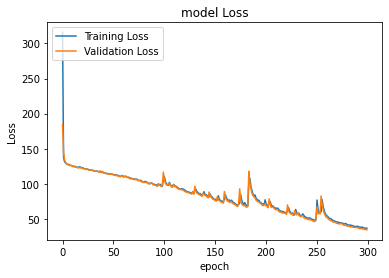

In [19]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [20]:
gc.collect()
# Decoding
print('Original:')
print(original_list[0])
print(original_list[1])
print(original_list[2])
print(original_list[3])
print('Decoded:')


train_inputs = tf.ragged.constant([i for i in inputs_list[:6]], dtype=np.float32)
train_seq_len = tf.cast(train_inputs.row_lengths(), tf.int32)
train_inputs = train_inputs.to_tensor(default_value=FEAT_MASK_VALUE)

decoded, _ = tf.nn.ctc_greedy_decoder(tf.transpose(
    model_predict.predict(train_inputs), (1, 0, 2)), train_seq_len)

d = tf.sparse.to_dense(decoded[0], default_value=-1).numpy()
str_decoded = [''.join([alphabets['num_to_char'][str(x)]
                       for x in np.asarray(row) if x != -1]) for row in d]

# print('decoded',str_decoded)
for s in str_decoded:
    # Replacing blank label to none
    # s = s.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    s = s.replace(alphabets['num_to_char']['0'], ' ')
    print(s)


Original:
የኤርትራ ባንዲራ ይውረድ ተብሎ ኤምባሲ ተደበደበ
መናገራቸው ን ምንጮቹ አስረድ ተዋል
የ ጠመንጃ ተኩስ ተከፈተ ና አራት የኤርትራ ወታደሮች ተገደሉ
ኢትዮጵያ ን መብት እንደሌላ ት አድርገው ለማቅረብ ሞክረ ዋል
Decoded:
የ መንብ ውረ ተብሎ ተምል ተደበ
መናራው ን ንች አስድ ተዋል
 ንላ ስ ተተ ና አራት የተርት ታርደች ተገ
ኢትዮጵያ ን መብት እንላ አር ቅከረብ ተረ 
የ  ው ይዛዳንት ኢትዮጵያ ና ኤርትራ የ ድንበር ግ ቸውን ሰም እን  ጥ ማባቸው ተለጠ
እ  አስፋልቱ ላይ የ ኰለኰ ለ ው ድንድይ መመና አላ ሳልፍ አለ
